In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [70]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_gaussian_observation import ARGaussianObservation
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.transformations.constrained_linear import ConstrainedLinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import time

# Generate synthetic data from constrained ARHMM

In [3]:
torch.manual_seed(0)

K = 3
D = 2
T = 100

As = [random_rotation(D) for _ in range(K)]
bounds = np.array([[0, 20], [0,40]])

#pi0 = np.array([1,2,1])
#P = np.array([[1,2,1], [1,0.5,1], [2,2,1]])

true_tran = ConstrainedLinearTransformation(K=K, d_in=D, d_out=D, As=As, bounds=bounds)
true_observation = ARGaussianObservation(K=K, D=D, M=0, transformation=true_tran)
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

# Fit a constrained ARHMM to the data

In [61]:
tran = ConstrainedLinearTransformation(K=K, d_in=D, d_out=D, bounds=bounds)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)
model = HMM(K=K, D=D, M=0, observation=observation)

In [62]:
num_iters = 1000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.005)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

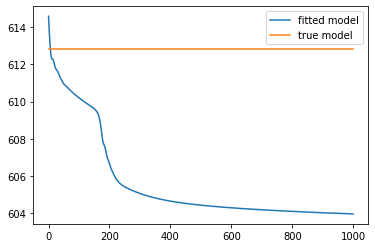

In [63]:
true_loss = true_model.loss(data)
plt.plot(losses, label='fitted model')
plt.plot(np.arange(num_iters), [true_loss]*num_iters, label='true model')
plt.legend()
plt.show()

In [64]:
tran.As

tensor([[[ 0.1589,  0.5299],
         [-0.1921,  0.2145]],

        [[-0.1915,  0.9896],
         [-1.4217,  0.0434]],

        [[ 0.9578, -0.1735],
         [-0.4227,  0.5952]]], dtype=torch.float64, requires_grad=True)

In [65]:
infer_z = model.most_likely_states(data)

perm = find_permutation(z.numpy(), infer_z, K1=K, K2=K)

model.permute(perm)
hmm_z = model.most_likely_states(data)

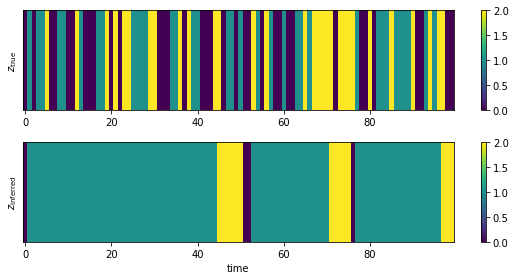

In [66]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(hmm_z[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()

# check prediction

In [67]:
x_predict_cond_z = k_step_prediction(model, z, data)

In [68]:
x_predict_cond_most_likely_z = k_step_prediction(model, hmm_z, data)

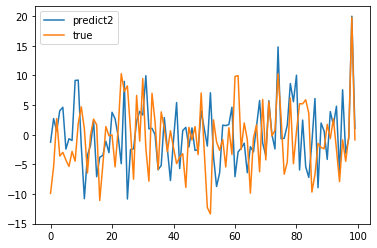

In [69]:
#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,0], label='predict2')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()

# Generate synthetic data from (unconstrained) ARHMM

In [141]:
true_tran_2 = LinearTransformation(K=K, d_in=D, d_out=D, As=As)
true_observation_2 = ARGaussianObservation(K=K, D=D, M=0, transformation=true_tran_2)
true_model_2 = HMM(K=K, D=D, M=0, observation=true_observation_2)

z_2, data_2 = true_model_2.sample(T, return_np=False)

In [142]:
data_2.shape

torch.Size([100, 2])

In [143]:
torch.min(data_2, dim=0)

torch.return_types.min(
values=tensor([-70.9968, -73.8978], dtype=torch.float64),
indices=tensor([46, 53]))

In [144]:
torch.max(data_2, dim=0)

torch.return_types.max(
values=tensor([75.6806, 86.7649], dtype=torch.float64),
indices=tensor([55, 98]))

# Define constrained ARHMM and fit

In [145]:
bounds_2 = np.array([[-50, 60], [-60, 50]])

In [146]:
tran_2 = ConstrainedLinearTransformation(K=K, d_in=D, d_out=D, bounds=bounds_2)
observation_2 = ARGaussianObservation(K=K, D=D, M=0, transformation=tran_2)
model_2 = HMM(K=K, D=D, M=0, observation=observation_2)

In [147]:
num_iters = 5000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer_2 = torch.optim.Adam(model_2.params, lr=0.001)

losses_2 = []
for i in np.arange(num_iters):

    optimizer_2.zero_grad()

    loss_2 = model_2.loss(data_2)    
    loss_2.backward(retain_graph=True)
    optimizer_2.step()
    
    loss_2 = loss_2.detach().numpy()
    losses_2.append(loss_2)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss_2))
        pbar.update(10)

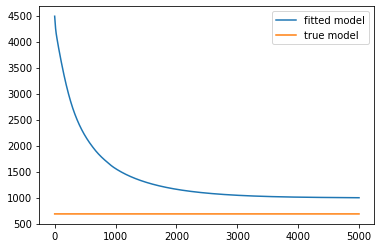

In [148]:
true_loss_2 = true_model_2.loss(data_2)
plt.plot(losses_2, label='fitted model')
plt.plot(np.arange(num_iters), [true_loss_2]*num_iters, label='true model')
plt.legend()
plt.show()

In [149]:
infer_z_2 = model_2.most_likely_states(data_2)

perm_2 = find_permutation(z_2.numpy(), infer_z_2, K1=K, K2=K)

model_2.permute(perm_2)
hmm_z_2 = model_2.most_likely_states(data_2)

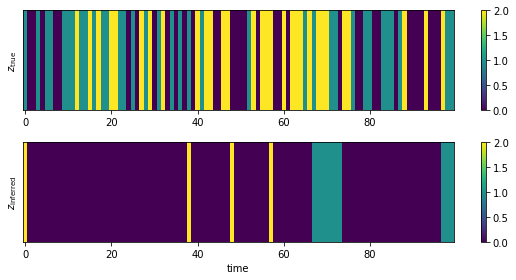

In [150]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z_2[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(hmm_z_2[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()

# check prediction

In [151]:
x_predict_cond_z_2 = k_step_prediction(model_2, z_2, data_2)

In [152]:
x_predict_cond_most_likely_z_2 = k_step_prediction(model_2, hmm_z_2, data_2)

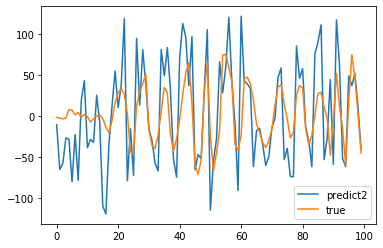

In [153]:
#plt.plot(x_predict_cond_z_2[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z_2[:,0], label='predict2')
plt.plot(data_2[:,0].numpy(), label='true')
plt.legend()

In [154]:
bounds_2

array([[-50,  60],
       [-60,  50]])

In [155]:
np.min(x_predict_cond_most_likely_z_2, axis=0)

array([-119.16607838, -127.5342831 ])

In [156]:
torch.exp(model_2.observation.log_sigmas)

tensor([[33.1904, 33.6211],
        [16.4233, 17.1283],
        [ 5.8567,  4.6138]], dtype=torch.float64, grad_fn=<ExpBackward>)

In [158]:
sample_z_2, sample_data_2 = model_2.sample(T)

In [160]:
np.min(sample_data_2, axis=0)

array([-131.17284873, -135.63535214])

In [162]:
torch.exp(observation_2.log_sigmas)

tensor([[33.1904, 33.6211],
        [16.4233, 17.1283],
        [ 5.8567,  4.6138]], dtype=torch.float64, grad_fn=<ExpBackward>)

In [164]:
out = observation_2._compute_mus_for(data_2)

In [165]:
out.shape

torch.Size([100, 3, 2])

In [167]:
torch.min(torch.min(out, dim=0)[0], dim=0)[0]

tensor([-50., -60.], dtype=torch.float64, grad_fn=<MinBackward0>)

In [168]:
torch.max(torch.max(out, dim=0)[0], dim=0)[0]

tensor([60., 50.], dtype=torch.float64, grad_fn=<MaxBackward0>)

In [171]:
bounds_2

array([[-50,  60],
       [-60,  50]])

Reflection: only put constraints (bounds) on the mean.

Next step: put constraints on the normal variable (mean + sigma * epsilon)

# test a simple normalizing flow

In [304]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [396]:
def scale_fn(inputs, bounds, centers=0):
    """
    inputs: (batch_size, D) or (D, )
    bounds: (D, 2)
    centers: (D, )
    """
    out = sigmoid(inputs-centers)
    
    out = out * (bounds[...,1] - bounds[...,0]) + bounds[...,0]
    return out

In [397]:
def dscale_fn(inputs, bounds, centers=0):
    """
    inputs: (batch_size, D) or (D, )
    bounds: (D, 2)
    centers: (D, )
    return: same shape of inputs
    """
    # (D,) * (batch_size, D)
    return (bounds[...,1]-bounds[...,0]) * dsigmoid(inputs-centers)

In [398]:
def scale_pdf(rvs, bounds, centers=0):
    return norm.pdf(rvs) / dscale_fn(rvs, bounds, centers)

In [399]:
from scipy.stats import norm

In [400]:
rvs = np.linspace(-2,2,100)[:,None]

In [401]:
vals = norm.pdf(rvs)

In [410]:
rvs.shape

(100, 1)

In [402]:
bounds = np.array([[1, 3]])
centers = np.array([2])

In [409]:
bounds[...,1]

array([3])

In [403]:
rvs_tran = scale_fn(rvs, bounds=bounds, centers=centers)

In [417]:
prob_rvs_tran = scale_pdf(rvs, bounds, centers)

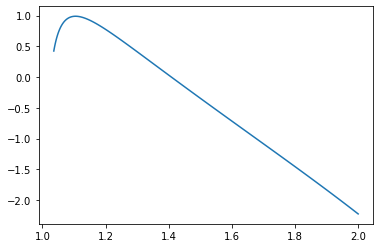

In [421]:
plt.plot(rvs_tran, np.log(prob_rvs_tran))

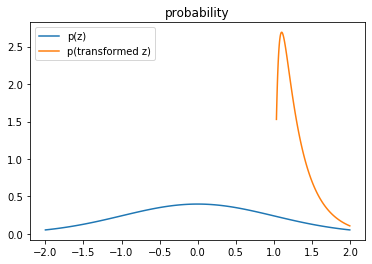

In [404]:
plt.plot(rvs, vals, label='p(z)')
plt.plot(rvs_tran, scale_pdf(rvs, bounds, centers), label='p(transformed z)')
plt.legend()
plt.title("probability");

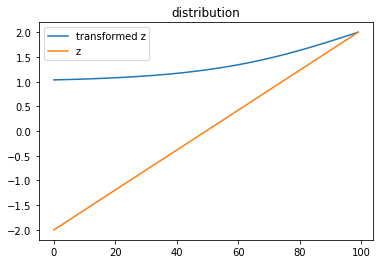

In [405]:
plt.plot(rvs_tran, label='transformed z')
plt.plot(rvs, label='z')
plt.legend()
plt.title("distribution");

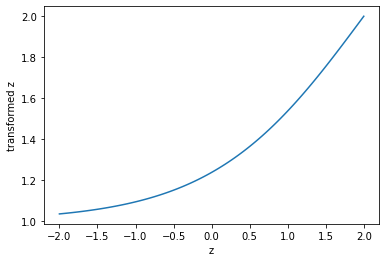

In [406]:
plt.plot(rvs, rvs_tran)
plt.xlabel('z')
plt.ylabel('transformed z');